In [1]:
%%capture
# libs
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.notebook import tqdm
# NLP packages
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# ML packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
# environment setup
tqdm.pandas()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
%load_ext blackcellmagic

ModuleNotFoundError: No module named 'blackcellmagic'

In [2]:
# initialize global vars

stop_words = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [3]:
def proc_text(text, stemming=None):
    """Helper function for processing the input text.
    Input:
        text (string): the text to be processed
        stemming (string): default=None
            - stem: stem words using nltk's PortStemmer
            - lemma: lemmatize words using nltk's WordNetLemmatizer
    """
    text_no_punct = ''.join([c for c in text if c not in punctuation])
    tokens = [word for word in word_tokenize(text_no_punct) if word not in stop_words]
    if stemming is not None:
        if stemming == 'lemma':
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        elif stemming == 'stem':
            tokens = [ps.stem(token) for token in tokens]
    return ' '.join(tokens)

In [4]:
data = pd.read_pickle('data/full_data_sentences.pkl')
data.drop(columns=['is_claim'], inplace=True)
data.head()

AttributeError: 'NoneType' object has no attribute 'axes'

In [5]:
data.shape

RecursionError: maximum recursion depth exceeded

In [6]:
data["sentences"] = data["sentences"].str.lower()
data["sentences_clean"] = data["sentences"].progress_apply(lambda x: proc_text(x))

In [7]:
data.head()

,sentences,sentences_clean
0,understanding the molecular basis of species f...,understanding molecular basis species formatio...
1,"however, the evolutionary forces that lead to ...",however evolutionary forces lead accumulation ...
2,segregation distorters are believed to be an i...,segregation distorters believed important sour...
3,"here, we collected viable sperm from first-gen...",collected viable sperm firstgeneration hybrid ...
4,we then genotyped millions of single nucleotid...,genotyped millions single nucleotide polymorph...


In [6]:
# Vectorizing text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.0008)
# vectorizing the clean text
train_txt_vect = vectorizer.fit_transform(data['sentences_clean'])

train_txt_vect.shape

NameError: name 'TfidfVectorizer' is not defined

In [7]:
true_k = 3
model_1 = KMeans(n_clusters=true_k, random_state=3)
model_1.fit(train_txt_vect)

NameError: name 'KMeans' is not defined

In [11]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=3)
reduced_features = pca.fit_transform(train_txt_vect.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model_1.cluster_centers_)

Text(0.5, 1.0, 'K-means sentences (3 clusters)')

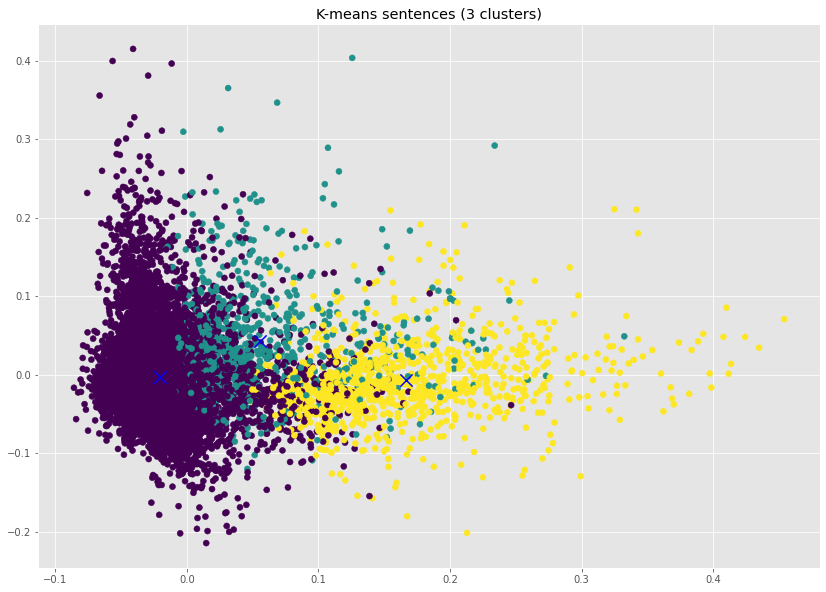

In [12]:
plt.figure(figsize=(14,10))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model_1.predict(train_txt_vect))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.title("""K-means sentences (3 clusters)""")

In [13]:
true_k = 4
model_2 = KMeans(n_clusters=true_k, random_state=3)
model_2.fit(train_txt_vect)

KMeans(n_clusters=4, random_state=3)

In [14]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=3)
reduced_features = pca.fit_transform(train_txt_vect.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model_2.cluster_centers_)

Text(0.5, 1.0, 'K-means sentences (4 clusters)')

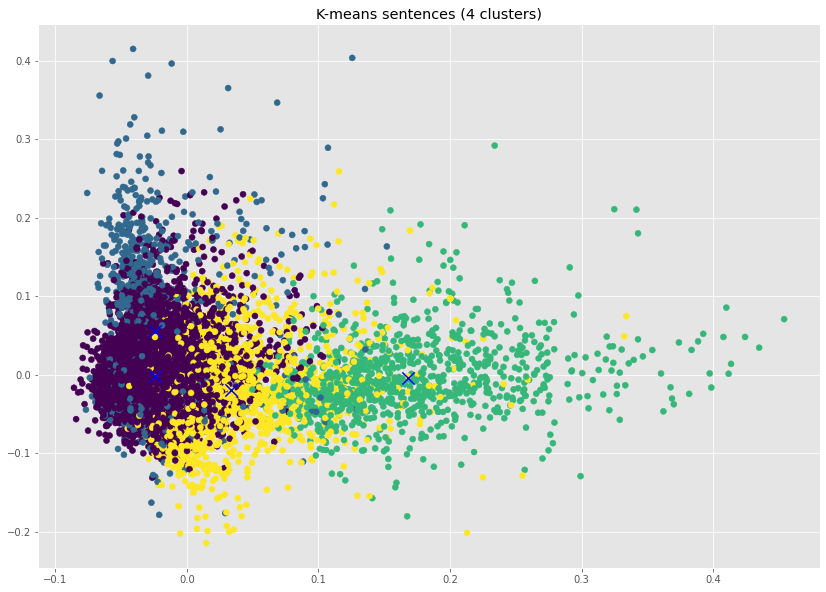

In [15]:
plt.figure(figsize=(14,10))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model_2.predict(train_txt_vect))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.title("""K-means sentences (4 clusters)""")

In [16]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    """ identifies the features with the highest mean tf_idf scores across each cluster"""
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

In [17]:
prediction = model_1.fit_predict(train_txt_vect.toarray())

In [18]:
dfs = get_top_features_cluster(train_txt_vect.toarray(), prediction, 20)

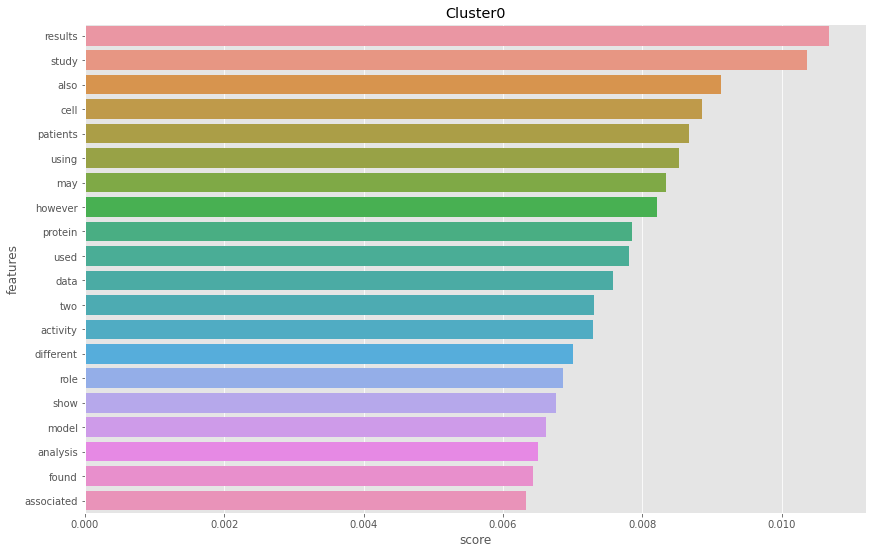

In [19]:
import seaborn as sns
plt.figure(figsize=(14,9))
plt.title("Cluster0")
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:20])
plt.savefig("cluster0.png");

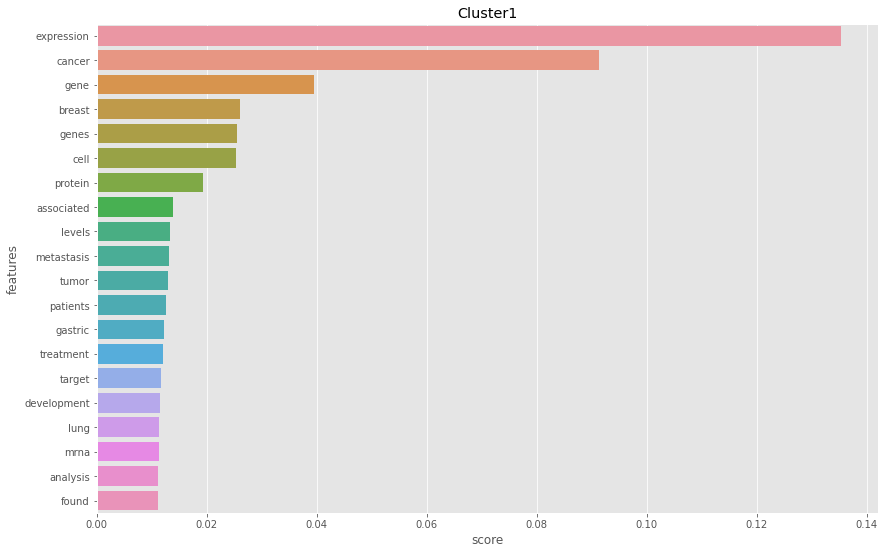

In [20]:
plt.figure(figsize=(14,9))
plt.title("Cluster1")
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:20])
plt.savefig("cluster1.png")

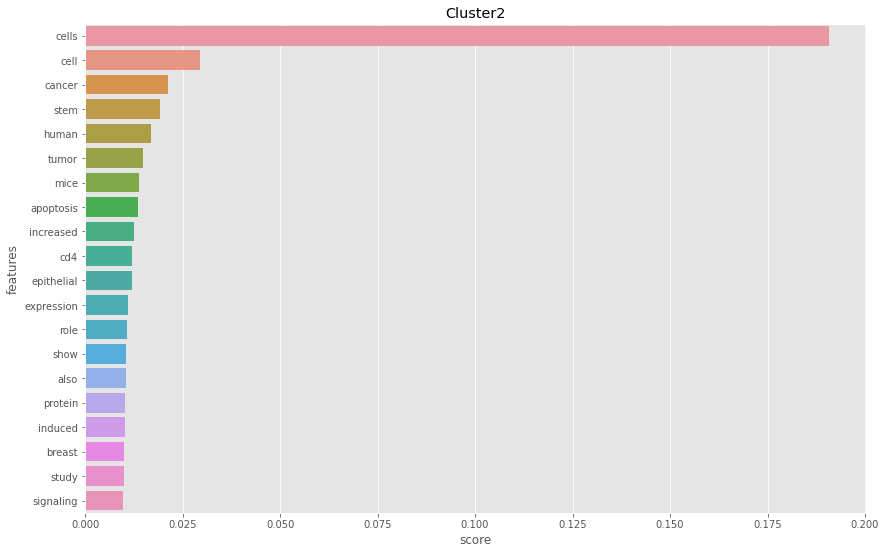

In [21]:
plt.figure(figsize=(14,9))
plt.title("Cluster2")
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:20])
plt.savefig("cluster2.png");

In [22]:
model_1.cluster_centers_

array([[ 1.06183306e-03,  5.08294169e-04,  2.41306741e-04, ...,
         5.17710886e-04,  5.92818804e-04,  9.15207110e-04],
       [ 1.46058891e-03,  2.16840434e-19,  0.00000000e+00, ...,
        -6.50521303e-19,  1.07657139e-03,  1.30104261e-18],
       [ 4.33680869e-19,  1.62630326e-19,  3.88104181e-04, ...,
         7.39874330e-04, -6.50521303e-19,  1.51788304e-18]])

In [23]:
data['tfidf vectors'] = train_txt_vect.toarray().tolist()

In [24]:
cluster_0 = []
cluster_1 = []
cluster_2 = []

for index in range(len(data)):
    cluster_0.append(spatial.distance.cosine(model_1.cluster_centers_[0], data['tfidf vectors'][index]))
    cluster_1.append(spatial.distance.cosine(model_1.cluster_centers_[1], data['tfidf vectors'][index]))
    cluster_2.append(spatial.distance.cosine(model_1.cluster_centers_[2], data['tfidf vectors'][index]))

/home/hanif/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [25]:
data['similarity with cluster 0'] = cluster_0
data['similarity with cluster 1'] = cluster_1
data['similarity with cluster 2'] = cluster_2

In [26]:
data.head()

,sentences,sentences_clean,tfidf vectors,similarity with cluster 0,similarity with cluster 1,similarity with cluster 2
0,understanding the molecular basis of species f...,understanding molecular basis species formatio...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.898364,0.972288,0.976698
1,"however, the evolutionary forces that lead to ...",however evolutionary forces lead accumulation ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.936807,0.980655,0.980081
2,segregation distorters are believed to be an i...,segregation distorters believed important sour...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.907426,0.974347,0.970543
3,"here, we collected viable sperm from first-gen...",collected viable sperm firstgeneration hybrid ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.955403,0.990772,0.993795
4,we then genotyped millions of single nucleotid...,genotyped millions single nucleotide polymorph...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.943996,0.981235,0.984777


In [29]:
data['similarity with cluster 2'].mean()

0.9544144619148136